In [54]:
# install for API
# ! pip install arcgis
# ! pip install pyzillow
# ! pip install python-zillow
# ! pip install progressbar2

In [1]:
import numpy as np
import pandas as pd
import requests
import pandas as pd
from bs4 import BeautifulSoup
import re
import zillow
import re
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from zillow import ValuationApi
pd.options.display.max_rows = 700\

import arcgis
from arcgis.gis import GIS
gis = GIS()

In [2]:
from zillow import ValuationApi

#insert your API key from zillow here
zid = 'X1-ZWz1gujpzjaayz_13bwv'

api = zillow.ValuationApi()

In [10]:
df = pd.read_csv('./dataset/openaddr-collected-us_south/us/ga/fulton.csv', na_values='NaN')

### Cleaning

In [29]:
df.dtypes
#df.index.astype(int)

index         int64
LON         float64
LAT         float64
NUMBER       object
STREET       object
CITY         object
POSTCODE      int64
COUNTY       object
dtype: object

In [12]:
#df.drop(columns=['DISTRICT','REGION','ID','HASH','UNIT'], inplace = True)
#df['COUNTY'] = 'Fulton'
#df.dropna(inplace = True)
#df.reset_index(inplace=True)
df.head()

,index,LON,LAT,NUMBER,STREET,CITY,POSTCODE,COUNTY
0,0,-84.383319,33.942985,370,Stone Mill Trail NE,Sandy Springs,30328,Fulton
1,1,-84.631323,33.635594,4382,Alysheba Drive,South Fulton,30213,Fulton
2,2,-84.363148,33.727186,747,East Confederate Avenue SE,Atlanta,30312,Fulton
3,3,-84.356985,33.854599,3648,Peachtree Road NE,Atlanta,30319,Fulton
4,4,-84.326463,34.063816,425,Hembree Forest Circle,Roswell,30076,Fulton


In [28]:
#clean up all the zips and city before i can convert to int.
df['POSTCODE'] = df['POSTCODE'].astype(int)

In [53]:
#this finds what is missing a zip
#df[df['POSTCODE'] == ' ']
(df == ' ').sum()

index       0
LON         0
LAT         0
NUMBER      0
STREET      0
CITY        0
POSTCODE    0
COUNTY      0
dtype: int64

In [14]:
#Brookdale rd
df[df['STREET'] == 'Brookdale Road']
df.loc[[384939,384940,384941], 'POSTCODE'] = 30022

In [16]:
# dropped all the hannaford addresses since i couldnt find the zip
df[df['STREET'] == 'Hannaford Walk']
df.drop(df.index[[387272,387273,387274,387275,387276,387277,387278,387279]], inplace=True)

In [20]:
# for creekview circle filled in zips and change city to south fulton
df.loc[range(387284,387312), 'POSTCODE'] = 30349
df.loc[range(387284,387312), 'CITY'] = 'South Fulton'

In [22]:
#replacing all empty zips  for hannaford lane
df.loc[[387312,387313], 'POSTCODE'] = 30097

In [24]:
#hospital parkway
df.loc[394694, 'POSTCODE'] = 30097

In [26]:
#for McGinnis
df.loc[range(387314,387331), 'POSTCODE'] = 30024

In [15]:
df.loc[406946, 'POSTCODE'] = 30097

### Zillow estimator

This progress bar is a personal choice and not needed to run the function, it does allow for some clear understanding at which stage your loop is at and the ETA for completion. It comes with its own share of issues though, please use with caution.

In [45]:
from progressbar import ProgressBar
bar = ProgressBar()

In [46]:
def Zestimate(zipcode):
    zestimate_list = []
    zipdf = df[df['POSTCODE'].isin(zipcode)]


    for i in bar(range(len(zipdf))):
        try:
            address = str(zipdf['NUMBER'][i]+' '+zipdf['STREET'][i]+'.,'+zipdf['CITY'][i]+', FL')
            postal_code = str(int(zipdf['POSTCODE'][i]))
            data = api.GetSearchResults(zid,address,postal_code)
            if data != None:
                zestimate_list.append(data.zestimate.amount)
            else:
                pass
        except:
            pass
    #Worth noting that many of the addresses do not have corresponding values in the zillow database.
    #The below print output shows how many the API missed.
    print('Missing Values:',len(zipdf)-len(zestimate_list),'Gathered:',"{0:.2f}".format((len(zestimate_list))/len(zipdf)*100),'%')
    
    # This is the print output, change the print out to your preference.
    zestimate_list = [x for x in zestimate_list if x is not None]
    zestimate_list = np.array(zestimate_list)
    statistics = stats.describe(zestimate_list)
    std = np.std(zestimate_list)
    median = np.median(zestimate_list)
    print('    ==========================================')
    print('             For Area', str(zipcode) )
    print('    ==========================================')
    print()
    print('     |  Values  |:',statistics[0])
    print('     | Minimum  |:', statistics[1][0])
    print('     | Maximum  |:', statistics[1][1])
    print('     |  Median  |:', median)
    print('     |   Mean   |:', float("{0:.2f}".format(statistics[2])))
    print('     |   Std    |:', float("{0:.2f}".format(std)))
    print('     | Skewness |:', float("{0:.2f}".format(statistics[4])))
    print('     | Kurtosis |:', float("{0:.2f}".format(statistics[5])))
    plt.hist(zestimate_list, edgecolor = 'black');
    plt.xlabel('House Value')
    plt.ylabel('Frequency')
    plt.xticks(rotation='vertical')
    return

100% (41213 of 41213) |##################| Elapsed Time: 0:22:59 Time:  0:22:59


Missing Values: 41109 Gathered: 0.25 %
             For Area [30310, 30311, 30314]

     |  Values  |: 90
     | Minimum  |: 54827
     | Maximum  |: 509531
     |  Median  |: 127064.0
     |   Mean   |: 133669.21
     |   Std    |: 59097.45
     | Skewness |: 3.32
     | Kurtosis |: 17.56


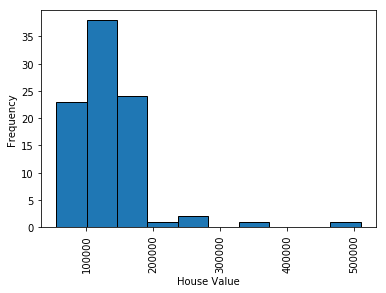

In [47]:
 a = Zestimate([30310,30311, 30314])

In [52]:
plt.savefig('a.jpeg')

<Figure size 432x288 with 0 Axes>

In [46]:
stats.describe(df['POSTCODE'])

DescribeResult(nobs=397236, minmax=(30002, 30363), mean=30239.07728151527, variance=16534.84027473602, skewness=-0.9437055435702032, kurtosis=-0.9072491878964337)

In [116]:
#zips in fulton
(30328, 30213, 30312, 30319, 30076, 30305, 30004, 30311, 30337,
30354, 30309, 30331, 30349, 30268, 30344, 30318, 30327, 30350,
30326, 30291, 30314, 30306, 30075, 30324, 30310, 30307, 30316,
30308, 30315, 30296, 30303, 30313, 30336, 30342, 30363, 30022,
30317, 30338, 30009, 30005, 30339, 30320, 30334, 30092, 30304,
30024, 30097, 30097, 30005, 30022, 30002, 30024, 30027, 30076, 30098)

In [32]:
atl =(30328, 30213, 30312, 30319, 30076, 30305, 30004, 30311, 30337)

In [33]:
df.CITY.unique()

array(['Sandy Springs', 'South Fulton', 'Atlanta', 'Roswell', 'Milton',
       'East Point', 'Palmetto', 'Union City', 'College Park',
       'Hapeville', 'Fairburn', 'Fulton County', 'Mountain Park',
       'Chattahoochee Hills', 'Alpharetta', 'Fayette County',
       'Johns Creek'], dtype=object)

In [ ]:
30024,30009,30114